--- QWILL Framework: Test Run (V_QWILL = sqrt(3) * V_bary) ---
--- Using fixed Y* = 0.68 ---

SPARC data loaded and prepared successfully.

Found 175 unique galaxies to analyze.
Calculating RMSE and initial velocities for all galaxies...
Calculation complete. Successfully analyzed 175 galaxies.

Overall Median RMSE [km/s]: 20.31

--- RMSE Distribution (Colored by Initial Velocity) ---


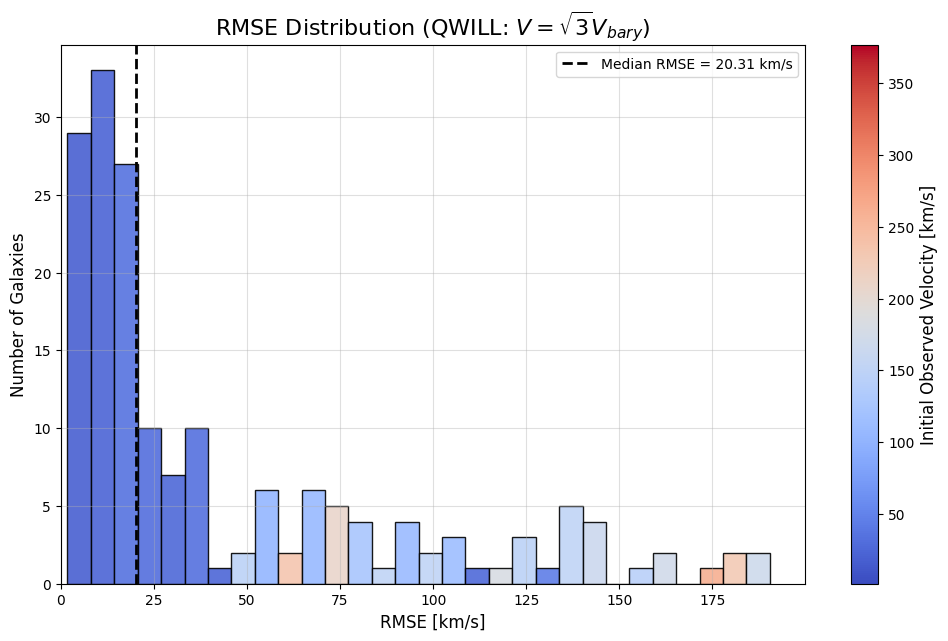


--- Detailed Results for Top 5 Best-Fit Galaxies ---

--- Galaxy: UGC04483 (RMSE: 1.77 km/s) ---


Radius,V_Observed,V_Predicted_QWILL
0.08,5.11,6.14
0.24,10.80,14.90
0.40,17.30,19.00
0.57,20.80,21.35
0.73,20.80,22.56
0.89,22.90,23.05
1.05,24.30,23.50
1.21,24.20,23.76



--- Galaxy: UGC07866 (RMSE: 2.30 km/s) ---


Radius,V_Observed,V_Predicted_QWILL
0.33,12.20,14.21
0.66,19.40,19.80
1.00,23.90,26.25
1.33,26.00,29.32
1.67,28.20,31.12
2.00,30.60,33.18
2.32,33.10,34.09



--- Galaxy: UGCA281 (RMSE: 2.40 km/s) ---


Radius,V_Observed,V_Predicted_QWILL
0.09,7.00,6.18
0.25,14.90,17.86
0.41,21.10,25.33
0.58,26.00,28.52
0.74,27.50,29.83
0.90,28.80,29.85
1.08,29.50,29.44



--- Galaxy: KK98-251 (RMSE: 2.93 km/s) ---


Radius,V_Observed,V_Predicted_QWILL
0.25,4.25,5.24
0.41,6.84,8.04
0.57,9.56,10.78
0.74,12.30,14.39
0.90,15.10,17.49
1.07,17.50,20.90
1.24,19.70,24.22
1.40,21.80,26.89
1.57,24.40,29.20
1.72,27.30,31.13



--- Galaxy: D512-2 (RMSE: 3.32 km/s) ---


Radius,V_Observed,V_Predicted_QWILL
0.96,22.90,22.36
1.92,33.50,32.15
2.88,37.20,32.08
3.83,35.90,31.92



--- QWILL Verification Run Complete ---



In [11]:
# =============================================================================
# WILL Framework: QWILL Test (V_QWILL = sqrt(3) * V_bary)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings

warnings.filterwarnings('ignore')

# --- 1. CONFIGURATION ---

PATH_TABLE1 = '/content/DATA/table1.dat'
PATH_TABLE2 = '/content/DATA/table2.dat'

Y_STAR_UNIVERSAL = 0.68  # Stellar mass-to-light ratio

# --- 2. DATA LOADING FUNCTIONS ---

def load_and_prepare_sparc_data(path_t1, path_t2):
    # Load table1.dat (galaxy properties)
    t1_colspecs = [(0, 11), (12, 17), (29, 36), (38, 44), (46, 52), (61, 67), (77, 85)]
    t1_names = ['Name', 'Dist', 'L_[3.6]', 'M_HI', 'M_*', 'Vmax', 'Sigma_D']
    df_t1 = pd.read_fwf(path_t1, colspecs=t1_colspecs, header=None, names=t1_names, comment='#')
    df_t1['Name'] = df_t1['Name'].str.strip()
    for col in df_t1.columns:
        if col != 'Name': df_t1[col] = pd.to_numeric(df_t1[col], errors='coerce')
    # Load table2.dat (rotation curve data)
    t2_colspecs = [(0, 11), (19, 25), (26, 32), (39, 45), (46, 52), (53, 59)]
    t2_names = ['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
    df_t2 = pd.read_fwf(path_t2, colspecs=t2_colspecs, header=None, names=t2_names, comment='#')
    df_t2['Name'] = df_t2['Name'].str.strip()
    num_cols_t2 = ['Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
    df_t2[num_cols_t2] = df_t2[num_cols_t2].apply(pd.to_numeric, errors='coerce')
    df_t2.dropna(subset=['Rad', 'Vobs'], inplace=True)
    print("SPARC data loaded and prepared successfully.")
    return df_t1, df_t2

# --- 3. QWILL MODEL ---

def v_bary(df_galaxy, y_star):
    """Calculates the baryonic rotation curve (sqrt of sum of squares)."""
    v_gas = df_galaxy['Vgas'].fillna(0)
    v_disk = df_galaxy['Vdisk'].fillna(0)
    v_bul = df_galaxy['Vbul'].fillna(0)
    return np.sqrt(v_gas**2 + y_star * (v_disk**2 + v_bul**2))

def v_qwill(df_galaxy, y_star):
    """Calculates the QWILL predicted rotation curve: sqrt(3) * V_bary."""
    v_bary_vals = v_bary(df_galaxy, y_star)
    return np.sqrt(3) * v_bary_vals

def rmse(v_obs, v_pred):
    """Root Mean Square Error."""
    return np.sqrt(np.mean((v_obs - v_pred)**2))

# --- 4. MAIN SCRIPT ---

if __name__ == "__main__":
    print("--- QWILL Framework: Test Run (V_QWILL = sqrt(3) * V_bary) ---")
    print(f"--- Using fixed Y* = {Y_STAR_UNIVERSAL} ---\n")

    df_t1, df_t2 = load_and_prepare_sparc_data(PATH_TABLE1, PATH_TABLE2)

    if df_t1 is not None and df_t2 is not None:
        all_galaxy_names = df_t1['Name'].unique()
        print(f"\nFound {len(all_galaxy_names)} unique galaxies to analyze.")

        print("Calculating RMSE and initial velocities for all galaxies...")

        results = []
        for name in all_galaxy_names:
            galaxy_data = df_t2[df_t2['Name'] == name]
            if len(galaxy_data) < 3:
                continue

            galaxy_data_sorted = galaxy_data.sort_values('Rad')
            v_initial = galaxy_data_sorted['Vobs'].iloc[0]

            v_pred = v_qwill(galaxy_data_sorted, Y_STAR_UNIVERSAL)
            v_obs = galaxy_data_sorted['Vobs']
            error = rmse(v_obs, v_pred)

            results.append({'Galaxy': name, 'RMSE': error, 'V_initial': v_initial})

        results_df = pd.DataFrame(results).dropna()
        print(f"Calculation complete. Successfully analyzed {len(results_df)} galaxies.\n")

        median_rmse = results_df['RMSE'].median()
        print(f"Overall Median RMSE [km/s]: {median_rmse:.2f}\n")

        # --- Distribution Plot ---
        print("--- RMSE Distribution (Colored by Initial Velocity) ---")
        num_bins = 30
        counts, bin_edges = np.histogram(results_df['RMSE'], bins=num_bins)
        bin_width = bin_edges[1] - bin_edges[0]

        vmin = results_df['V_initial'].min()
        vmax = results_df['V_initial'].max()
        cmap = plt.get_cmap('coolwarm')
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        fig, ax = plt.subplots(figsize=(12, 7))
        for i in range(num_bins):
            bin_min, bin_max = bin_edges[i], bin_edges[i+1]
            bin_galaxies_df = results_df[(results_df['RMSE'] >= bin_min) & (results_df['RMSE'] < bin_max)]
            if not bin_galaxies_df.empty:
                avg_v_initial_in_bin = bin_galaxies_df['V_initial'].mean()
                bar_color = cmap(norm(avg_v_initial_in_bin))
            else:
                bar_color = 'lightgrey'
            ax.bar(bin_edges[i], counts[i], width=bin_width, align='edge', color=bar_color, edgecolor='k', alpha=0.9)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Initial Observed Velocity [km/s]', fontsize=12)
        ax.set_title('RMSE Distribution (QWILL: $V=\\sqrt{3} V_{bary}$)', fontsize=16)
        ax.set_xlabel('RMSE [km/s]', fontsize=12)
        ax.set_ylabel('Number of Galaxies', fontsize=12)
        ax.axvline(median_rmse, color='black', linestyle='--', linewidth=2, label=f"Median RMSE = {median_rmse:.2f} km/s")
        ax.legend()
        ax.grid(True, alpha=0.4)
        ax.set_xlim(left=0)
        plt.show()

        print("\n--- Detailed Results for Top 5 Best-Fit Galaxies ---")
        best_fits_df = results_df.sort_values('RMSE').head(5)

        for index, row in best_fits_df.iterrows():
            galaxy_name = row['Galaxy']
            galaxy_rmse = row['RMSE']

            print(f"\n--- Galaxy: {galaxy_name} (RMSE: {galaxy_rmse:.2f} km/s) ---")

            galaxy_data = df_t2[df_t2['Name'] == galaxy_name].sort_values('Rad').copy()
            v_pred = v_qwill(galaxy_data, Y_STAR_UNIVERSAL)

            comparison_table = pd.DataFrame({
                'Radius': galaxy_data['Rad'],
                'V_Observed': galaxy_data['Vobs'],
                'V_Predicted_QWILL': v_pred
            })
            display(HTML(comparison_table.to_html(index=False, float_format='{:.2f}'.format)))

    print("\n--- QWILL Verification Run Complete ---\n")


In [1]:
# =============================================================================
# WILL Framework: Sensitivity Analysis for QWILL
# Test: How Median RMSE depends on the choice of Y_star
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings

# --- 1. CONFIGURATION ---

warnings.filterwarnings('ignore')

# Paths to your data files
PATH_TABLE1 = '/content/DATA/table1.dat'
PATH_TABLE2 = '/content/DATA/table2.dat'

# --- 2. DATA LOADING & MODEL FUNCTIONS (from your previous script) ---

def load_and_prepare_sparc_data(path_t1, path_t2):
    """Loads and prepares SPARC data."""
    try:
        t1_colspecs = [(0, 11), (12, 17), (29, 36), (38, 44), (46, 52), (61, 67), (77, 85)]
        t1_names = ['Name', 'Dist', 'L_[3.6]', 'M_HI', 'M_*', 'Vmax', 'Sigma_D']
        df_t1 = pd.read_fwf(path_t1, colspecs=t1_colspecs, header=None, names=t1_names, comment='#')
        df_t1['Name'] = df_t1['Name'].str.strip()
        for col in df_t1.columns:
            if col != 'Name': df_t1[col] = pd.to_numeric(df_t1[col], errors='coerce')

        t2_colspecs = [(0, 11), (19, 25), (26, 32), (39, 45), (46, 52), (53, 59)]
        t2_names = ['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df_t2 = pd.read_fwf(path_t2, colspecs=t2_colspecs, header=None, names=t2_names, comment='#')
        df_t2['Name'] = df_t2['Name'].str.strip()
        num_cols_t2 = ['Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df_t2[num_cols_t2] = df_t2[num_cols_t2].apply(pd.to_numeric, errors='coerce')
        df_t2.dropna(subset=['Rad', 'Vobs'], inplace=True)
        print("SPARC data loaded successfully.")
        return df_t1, df_t2
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure data paths are correct.")
        return None, None

def v_bary(df_galaxy, y_star):
    """Calculates the baryonic rotation curve velocity."""
    v_gas = df_galaxy['Vgas'].fillna(0)
    v_disk = df_galaxy['Vdisk'].fillna(0)
    v_bul = df_galaxy['Vbul'].fillna(0)
    return np.sqrt(v_gas**2 + y_star * (v_disk**2 + v_bul**2))

def v_qwill(v_bary_vals):
    """Calculates the QWILL predicted velocity from baryonic velocity."""
    return np.sqrt(3) * v_bary_vals

def rmse(v_obs, v_pred):
    """Calculates Root Mean Square Error."""
    return np.sqrt(np.mean((v_obs - v_pred)**2))

# --- 3. MAIN SCRIPT: SENSITIVITY ANALYSIS ---

if __name__ == "__main__":
    print("--- Starting Sensitivity Analysis for QWILL Model ---")

    df_t1, df_t2 = load_and_prepare_sparc_data(PATH_TABLE1, PATH_TABLE2)

    if df_t1 is not None and df_t2 is not None:
        all_galaxy_names = df_t1['Name'].unique()

        # Define the range of Y_star values to test
        y_star_range = np.arange(0.4, 1.02, 0.02)
        sensitivity_results = []

        print(f"\\nTesting {len(y_star_range)} values for Y_star...")

        # Loop over each Y_star value
        for y_star_val in y_star_range:
            galaxy_errors = []
            # Calculate RMSE for every galaxy with the current Y_star
            for name in all_galaxy_names:
                galaxy_data = df_t2[df_t2['Name'] == name]
                if len(galaxy_data) < 3:
                    continue

                v_bary_calculated = v_bary(galaxy_data, y_star_val)
                v_pred = v_qwill(v_bary_calculated)
                v_obs = galaxy_data['Vobs']
                error = rmse(v_obs, v_pred)
                galaxy_errors.append(error)

            # Calculate the median RMSE for this Y_star value
            median_rmse = np.nanmedian(galaxy_errors)
            sensitivity_results.append({'Y_star': y_star_val, 'Median_RMSE': median_rmse})
            print(f"  Y* = {y_star_val:.2f} -> Median RMSE = {median_rmse:.2f} km/s")

        # Convert results to a DataFrame for easy plotting
        sensitivity_df = pd.DataFrame(sensitivity_results)
        print("\\nAnalysis complete. Generating plot...")

        # --- 4. PLOTTING THE RESULTS ---

        # Find the minimum RMSE and corresponding Y_star
        min_rmse_row = sensitivity_df.loc[sensitivity_df['Median_RMSE'].idxmin()]
        min_y_star = min_rmse_row['Y_star']
        min_rmse = min_rmse_row['Median_RMSE']

        # Your original Y_star value for reference
        original_y_star = 0.68
        original_rmse = sensitivity_df[np.isclose(sensitivity_df['Y_star'], original_y_star)]['Median_RMSE'].iloc[0]

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 8))

        ax.plot(sensitivity_df['Y_star'], sensitivity_df['Median_RMSE'], marker='o', linestyle='-', color='royalblue', label='Median RMSE vs. $\\Upsilon_*$')

        # Highlight the minimum point
        ax.plot(min_y_star, min_rmse, 'o', color='red', markersize=10, label=f'Minimum RMSE: {min_rmse:.2f} at $\\Upsilon_*={min_y_star:.2f}$')

        # Highlight your original point
        ax.plot(original_y_star, original_rmse, 's', color='green', markersize=10, label=f'Your Original Value: {original_rmse:.2f} at $\\Upsilon_*={original_y_star}$')

        ax.set_title('Sensitivity of QWILL Model to Stellar Mass-to-Light Ratio ($\\Upsilon_*$)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Stellar Mass-to-Light Ratio ($\\Upsilon_*$)', fontsize=12)
        ax.set_ylabel('Median RMSE [km/s] (across 175 galaxies)', fontsize=12)
        ax.legend(fontsize=11)

        # Add text annotations for clarity
        ax.text(min_y_star, min_rmse + 0.5, 'Global Minimum', ha='center', va='bottom', color='red')
        ax.text(original_y_star, original_rmse + 0.5, 'Your Value', ha='center', va='bottom', color='green')


        plt.tight_layout()
        plt.savefig('Y_star_sensitivity_analysis.png', dpi=300)
        plt.show()

        print("\\n--- Sensitivity Analysis Complete. Plot saved as 'Y_star_sensitivity_analysis.png' ---")

--- Starting Sensitivity Analysis for QWILL Model ---
Error: [Errno 2] No such file or directory: '/content/DATA/table1.dat'. Please ensure data paths are correct.


--- Starting Sensitivity Analysis for QWILL Model ---
SPARC data loaded successfully.
\nTesting 31 values for Y_star...
  Y* = 0.40 -> Median RMSE = 23.33 km/s
  Y* = 0.42 -> Median RMSE = 23.04 km/s
  Y* = 0.44 -> Median RMSE = 22.54 km/s
  Y* = 0.46 -> Median RMSE = 22.10 km/s
  Y* = 0.48 -> Median RMSE = 22.08 km/s
  Y* = 0.50 -> Median RMSE = 22.04 km/s
  Y* = 0.52 -> Median RMSE = 21.61 km/s
  Y* = 0.54 -> Median RMSE = 21.45 km/s
  Y* = 0.56 -> Median RMSE = 21.29 km/s
  Y* = 0.58 -> Median RMSE = 21.14 km/s
  Y* = 0.60 -> Median RMSE = 20.98 km/s
  Y* = 0.62 -> Median RMSE = 20.61 km/s
  Y* = 0.64 -> Median RMSE = 20.35 km/s
  Y* = 0.66 -> Median RMSE = 20.23 km/s
  Y* = 0.68 -> Median RMSE = 20.31 km/s
  Y* = 0.70 -> Median RMSE = 20.48 km/s
  Y* = 0.72 -> Median RMSE = 20.26 km/s
  Y* = 0.74 -> Median RMSE = 20.57 km/s
  Y* = 0.76 -> Median RMSE = 20.86 km/s
  Y* = 0.78 -> Median RMSE = 21.24 km/s
  Y* = 0.80 -> Median RMSE = 21.99 km/s
  Y* = 0.82 -> Median RMSE = 21.97 km/s


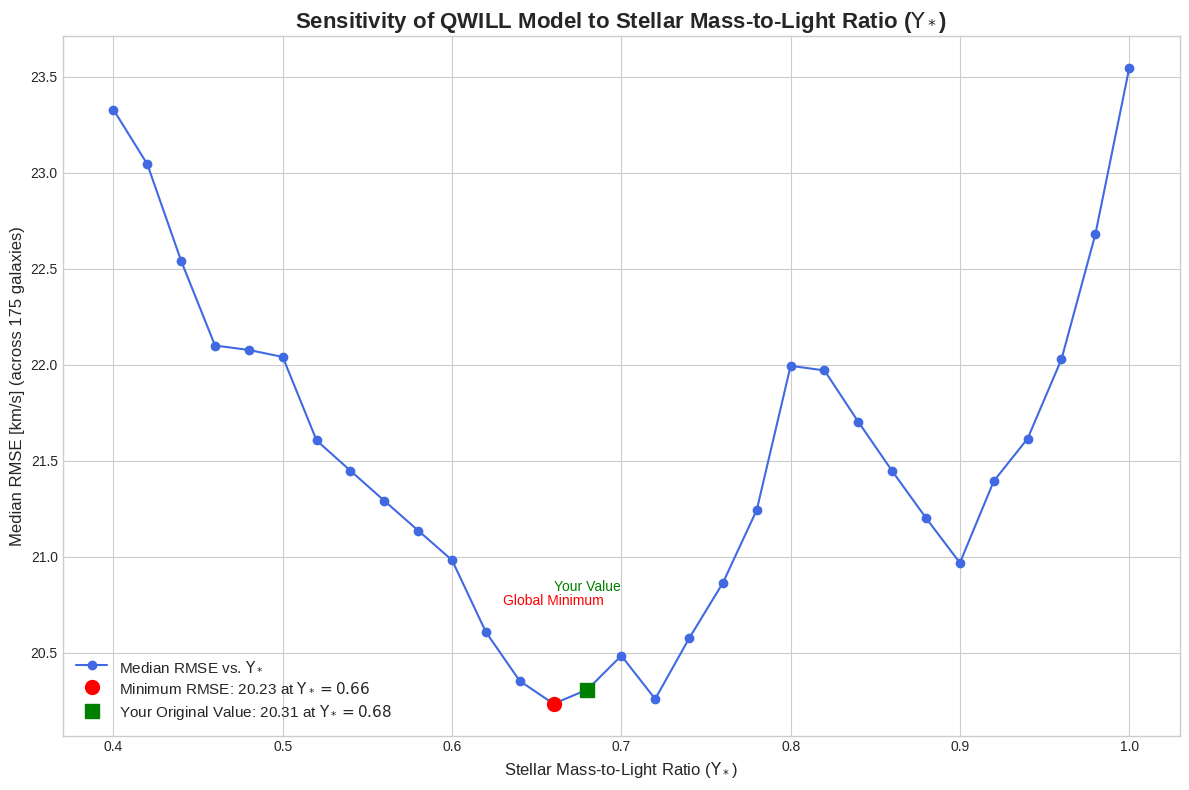

\n--- Sensitivity Analysis Complete. Plot saved as 'Y_star_sensitivity_analysis.png' ---


In [2]:
# =============================================================================
# WILL Framework: Sensitivity Analysis for QWILL
# Test: How Median RMSE depends on the choice of Y_star
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings

# --- 1. CONFIGURATION ---

warnings.filterwarnings('ignore')

# Paths to your data files
PATH_TABLE1 = '/content/DATA/table1.dat'
PATH_TABLE2 = '/content/DATA/table2.dat'

# --- 2. DATA LOADING & MODEL FUNCTIONS (from your previous script) ---

def load_and_prepare_sparc_data(path_t1, path_t2):
    """Loads and prepares SPARC data."""
    try:
        t1_colspecs = [(0, 11), (12, 17), (29, 36), (38, 44), (46, 52), (61, 67), (77, 85)]
        t1_names = ['Name', 'Dist', 'L_[3.6]', 'M_HI', 'M_*', 'Vmax', 'Sigma_D']
        df_t1 = pd.read_fwf(path_t1, colspecs=t1_colspecs, header=None, names=t1_names, comment='#')
        df_t1['Name'] = df_t1['Name'].str.strip()
        for col in df_t1.columns:
            if col != 'Name': df_t1[col] = pd.to_numeric(df_t1[col], errors='coerce')

        t2_colspecs = [(0, 11), (19, 25), (26, 32), (39, 45), (46, 52), (53, 59)]
        t2_names = ['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df_t2 = pd.read_fwf(path_t2, colspecs=t2_colspecs, header=None, names=t2_names, comment='#')
        df_t2['Name'] = df_t2['Name'].str.strip()
        num_cols_t2 = ['Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df_t2[num_cols_t2] = df_t2[num_cols_t2].apply(pd.to_numeric, errors='coerce')
        df_t2.dropna(subset=['Rad', 'Vobs'], inplace=True)
        print("SPARC data loaded successfully.")
        return df_t1, df_t2
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure data paths are correct.")
        return None, None

def v_bary(df_galaxy, y_star):
    """Calculates the baryonic rotation curve velocity."""
    v_gas = df_galaxy['Vgas'].fillna(0)
    v_disk = df_galaxy['Vdisk'].fillna(0)
    v_bul = df_galaxy['Vbul'].fillna(0)
    return np.sqrt(v_gas**2 + y_star * (v_disk**2 + v_bul**2))

def v_qwill(v_bary_vals):
    """Calculates the QWILL predicted velocity from baryonic velocity."""
    return np.sqrt(3) * v_bary_vals

def rmse(v_obs, v_pred):
    """Calculates Root Mean Square Error."""
    return np.sqrt(np.mean((v_obs - v_pred)**2))

# --- 3. MAIN SCRIPT: SENSITIVITY ANALYSIS ---

if __name__ == "__main__":
    print("--- Starting Sensitivity Analysis for QWILL Model ---")

    df_t1, df_t2 = load_and_prepare_sparc_data(PATH_TABLE1, PATH_TABLE2)

    if df_t1 is not None and df_t2 is not None:
        all_galaxy_names = df_t1['Name'].unique()

        # Define the range of Y_star values to test
        y_star_range = np.arange(0.4, 1.02, 0.02)
        sensitivity_results = []

        print(f"\\nTesting {len(y_star_range)} values for Y_star...")

        # Loop over each Y_star value
        for y_star_val in y_star_range:
            galaxy_errors = []
            # Calculate RMSE for every galaxy with the current Y_star
            for name in all_galaxy_names:
                galaxy_data = df_t2[df_t2['Name'] == name]
                if len(galaxy_data) < 3:
                    continue

                v_bary_calculated = v_bary(galaxy_data, y_star_val)
                v_pred = v_qwill(v_bary_calculated)
                v_obs = galaxy_data['Vobs']
                error = rmse(v_obs, v_pred)
                galaxy_errors.append(error)

            # Calculate the median RMSE for this Y_star value
            median_rmse = np.nanmedian(galaxy_errors)
            sensitivity_results.append({'Y_star': y_star_val, 'Median_RMSE': median_rmse})
            print(f"  Y* = {y_star_val:.2f} -> Median RMSE = {median_rmse:.2f} km/s")

        # Convert results to a DataFrame for easy plotting
        sensitivity_df = pd.DataFrame(sensitivity_results)
        print("\\nAnalysis complete. Generating plot...")

        # --- 4. PLOTTING THE RESULTS ---

        # Find the minimum RMSE and corresponding Y_star
        min_rmse_row = sensitivity_df.loc[sensitivity_df['Median_RMSE'].idxmin()]
        min_y_star = min_rmse_row['Y_star']
        min_rmse = min_rmse_row['Median_RMSE']

        # Your original Y_star value for reference
        original_y_star = 0.68
        original_rmse = sensitivity_df[np.isclose(sensitivity_df['Y_star'], original_y_star)]['Median_RMSE'].iloc[0]

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 8))

        ax.plot(sensitivity_df['Y_star'], sensitivity_df['Median_RMSE'], marker='o', linestyle='-', color='royalblue', label='Median RMSE vs. $\\Upsilon_*$')

        # Highlight the minimum point
        ax.plot(min_y_star, min_rmse, 'o', color='red', markersize=10, label=f'Minimum RMSE: {min_rmse:.2f} at $\\Upsilon_*={min_y_star:.2f}$')

        # Highlight your original point
        ax.plot(original_y_star, original_rmse, 's', color='green', markersize=10, label=f'Your Original Value: {original_rmse:.2f} at $\\Upsilon_*={original_y_star}$')

        ax.set_title('Sensitivity of QWILL Model to Stellar Mass-to-Light Ratio ($\\Upsilon_*$)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Stellar Mass-to-Light Ratio ($\\Upsilon_*$)', fontsize=12)
        ax.set_ylabel('Median RMSE [km/s] (across 175 galaxies)', fontsize=12)
        ax.legend(fontsize=11)

        # Add text annotations for clarity
        ax.text(min_y_star, min_rmse + 0.5, 'Global Minimum', ha='center', va='bottom', color='red')
        ax.text(original_y_star, original_rmse + 0.5, 'Your Value', ha='center', va='bottom', color='green')


        plt.tight_layout()
        plt.savefig('Y_star_sensitivity_analysis.png', dpi=300)
        plt.show()

        print("\\n--- Sensitivity Analysis Complete. Plot saved as 'Y_star_sensitivity_analysis.png' ---")

--- Starting Multiplier (C) Sensitivity Analysis ---
--- Using fixed Y* = 0.66 ---
SPARC data loaded successfully.
\nTesting 26 values for multiplier C...
  C = 1.500 -> Median RMSE = 24.49 km/s
  C = 1.520 -> Median RMSE = 23.88 km/s
  C = 1.540 -> Median RMSE = 23.54 km/s
  C = 1.560 -> Median RMSE = 22.98 km/s
  C = 1.580 -> Median RMSE = 22.88 km/s
  C = 1.600 -> Median RMSE = 22.22 km/s
  C = 1.620 -> Median RMSE = 21.75 km/s
  C = 1.640 -> Median RMSE = 21.75 km/s
  C = 1.660 -> Median RMSE = 21.49 km/s
  C = 1.680 -> Median RMSE = 21.03 km/s
  C = 1.700 -> Median RMSE = 20.66 km/s
  C = 1.720 -> Median RMSE = 20.31 km/s
  C = 1.740 -> Median RMSE = 20.28 km/s
  C = 1.760 -> Median RMSE = 20.37 km/s
  C = 1.780 -> Median RMSE = 19.95 km/s
  C = 1.800 -> Median RMSE = 19.60 km/s
  C = 1.820 -> Median RMSE = 19.28 km/s
  C = 1.840 -> Median RMSE = 19.95 km/s
  C = 1.860 -> Median RMSE = 20.65 km/s
  C = 1.880 -> Median RMSE = 21.55 km/s
  C = 1.900 -> Median RMSE = 21.26 km/s
  C =

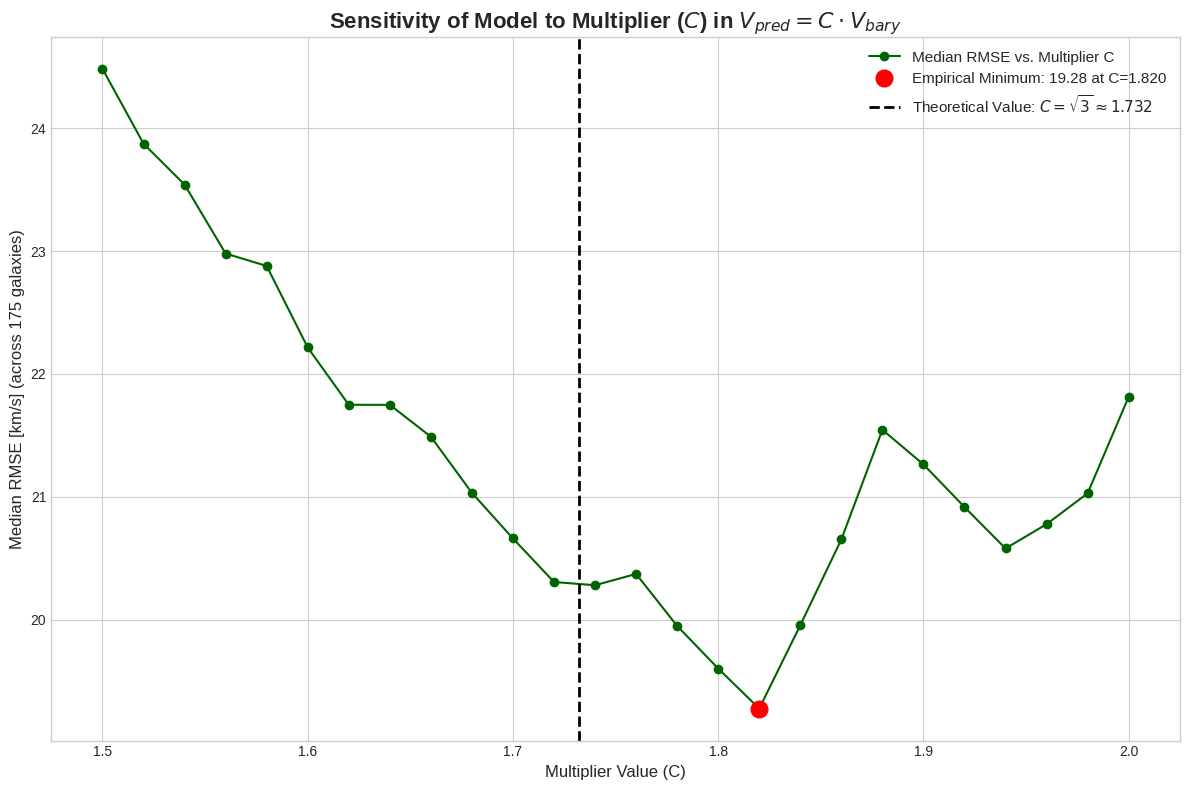

\n--- Multiplier Sensitivity Analysis Complete. Plot saved as 'C_multiplier_sensitivity.png' ---


In [3]:
# =============================================================================
# WILL Framework: Sensitivity Analysis for QWILL
# Test: How Median RMSE depends on the choice of the multiplier C
# in the formula V = C * V_bary
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings

# --- 1. CONFIGURATION ---

warnings.filterwarnings('ignore')

# Paths to your data files
PATH_TABLE1 = '/content/DATA/table1.dat'
PATH_TABLE2 = '/content/DATA/table2.dat'

# Using the optimal Y_star found in the previous test
Y_STAR_FIXED = 0.66

# --- 2. DATA LOADING & MODEL FUNCTIONS ---

def load_and_prepare_sparc_data(path_t1, path_t2):
    """Loads and prepares SPARC data."""
    try:
        t1_colspecs = [(0, 11), (12, 17), (29, 36), (38, 44), (46, 52), (61, 67), (77, 85)]
        t1_names = ['Name', 'Dist', 'L_[3.6]', 'M_HI', 'M_*', 'Vmax', 'Sigma_D']
        df_t1 = pd.read_fwf(path_t1, colspecs=t1_colspecs, header=None, names=t1_names, comment='#')
        df_t1['Name'] = df_t1['Name'].str.strip()
        for col in df_t1.columns:
            if col != 'Name': df_t1[col] = pd.to_numeric(df_t1[col], errors='coerce')

        t2_colspecs = [(0, 11), (19, 25), (26, 32), (39, 45), (46, 52), (53, 59)]
        t2_names = ['Name', 'Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df_t2 = pd.read_fwf(path_t2, colspecs=t2_colspecs, header=None, names=t2_names, comment='#')
        df_t2['Name'] = df_t2['Name'].str.strip()
        num_cols_t2 = ['Rad', 'Vobs', 'Vgas', 'Vdisk', 'Vbul']
        df_t2[num_cols_t2] = df_t2[num_cols_t2].apply(pd.to_numeric, errors='coerce')
        df_t2.dropna(subset=['Rad', 'Vobs'], inplace=True)
        print("SPARC data loaded successfully.")
        return df_t1, df_t2
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure data paths are correct.")
        return None, None

def v_bary(df_galaxy, y_star):
    """Calculates the baryonic rotation curve velocity."""
    v_gas = df_galaxy['Vgas'].fillna(0)
    v_disk = df_galaxy['Vdisk'].fillna(0)
    v_bul = df_galaxy['Vbul'].fillna(0)
    return np.sqrt(v_gas**2 + y_star * (v_disk**2 + v_bul**2))

def v_pred_model(v_bary_vals, C):
    """Calculates the predicted velocity using a variable multiplier C."""
    return C * v_bary_vals

def rmse(v_obs, v_pred):
    """Calculates Root Mean Square Error."""
    return np.sqrt(np.mean((v_obs - v_pred)**2))

# --- 3. MAIN SCRIPT: MULTIPLIER SENSITIVITY ANALYSIS ---

if __name__ == "__main__":
    print("--- Starting Multiplier (C) Sensitivity Analysis ---")
    print(f"--- Using fixed Y* = {Y_STAR_FIXED} ---")

    df_t1, df_t2 = load_and_prepare_sparc_data(PATH_TABLE1, PATH_TABLE2)

    if df_t1 is not None and df_t2 is not None:
        all_galaxy_names = df_t1['Name'].unique()

        # Define the range of Multiplier (C) values to test
        C_range = np.arange(1.5, 2.02, 0.02)
        sensitivity_results = []

        print(f"\\nTesting {len(C_range)} values for multiplier C...")

        # Loop over each C value
        for c_val in C_range:
            galaxy_errors = []
            # Calculate RMSE for every galaxy with the current C
            for name in all_galaxy_names:
                galaxy_data = df_t2[df_t2['Name'] == name]
                if len(galaxy_data) < 3:
                    continue

                v_bary_calculated = v_bary(galaxy_data, Y_STAR_FIXED)
                v_predicted = v_pred_model(v_bary_calculated, c_val)
                v_obs = galaxy_data['Vobs']
                error = rmse(v_obs, v_predicted)
                galaxy_errors.append(error)

            # Calculate the median RMSE for this C value
            median_rmse = np.nanmedian(galaxy_errors)
            sensitivity_results.append({'C_multiplier': c_val, 'Median_RMSE': median_rmse})
            print(f"  C = {c_val:.3f} -> Median RMSE = {median_rmse:.2f} km/s")

        # Convert results to a DataFrame for easy plotting
        sensitivity_df = pd.DataFrame(sensitivity_results)
        print("\\nAnalysis complete. Generating plot...")

        # --- 4. PLOTTING THE RESULTS ---

        # Find the minimum RMSE and corresponding C
        min_rmse_row = sensitivity_df.loc[sensitivity_df['Median_RMSE'].idxmin()]
        min_C = min_rmse_row['C_multiplier']
        min_rmse = min_rmse_row['Median_RMSE']

        # Theoretical value
        sqrt_3 = np.sqrt(3)

        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 8))

        ax.plot(sensitivity_df['C_multiplier'], sensitivity_df['Median_RMSE'], marker='o', linestyle='-', color='darkgreen', label='Median RMSE vs. Multiplier C')

        # Highlight the minimum point found
        ax.plot(min_C, min_rmse, 'o', color='red', markersize=12, label=f'Empirical Minimum: {min_rmse:.2f} at C={min_C:.3f}')

        # Highlight the theoretical prediction
        ax.axvline(x=sqrt_3, color='black', linestyle='--', linewidth=2, label=f'Theoretical Value: $C = \\sqrt{{3}} \\approx {sqrt_3:.3f}$')

        ax.set_title('Sensitivity of Model to Multiplier ($C$) in $V_{pred} = C \\cdot V_{bary}$', fontsize=16, fontweight='bold')
        ax.set_xlabel('Multiplier Value (C)', fontsize=12)
        ax.set_ylabel('Median RMSE [km/s] (across 175 galaxies)', fontsize=12)
        ax.legend(fontsize=11)

        plt.tight_layout()
        plt.savefig('C_multiplier_sensitivity.png', dpi=300)
        plt.show()

        print("\\n--- Multiplier Sensitivity Analysis Complete. Plot saved as 'C_multiplier_sensitivity.png' ---")